In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import onnx
import onnxruntime as ort

In [2]:
model_name = 'efficientnetv2_rw_t'
model = timm.create_model(model_name, pretrained=True)

model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

In [3]:
image = cv2.imread('assets/dog1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(500, 500, 3)

In [4]:
config = resolve_data_config((), model=model)
transform = create_transform(**config)
transform

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

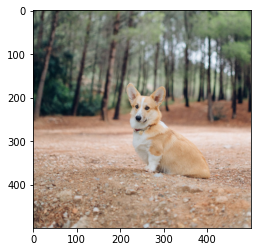

In [5]:
plt.imshow(image)

In [6]:
with open('assets/imagenet_classes.txt', 'r') as f:
    categories = [s.strip() for s in f.readlines()]
    
categories[:5]    

['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead']

In [7]:
input_tensor = transform(Image.fromarray(image))
input_tensor = input_tensor.unsqueeze(0)

input_tensor.shape

torch.Size([1, 3, 224, 224])

In [8]:
k = 10

with torch.inference_mode():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=-1)
    probs_topk, ids_topk = torch.topk(probs, k, dim=-1)
    
probs_topk.shape, ids_topk.shape

(torch.Size([1, 10]), torch.Size([1, 10]))

In [9]:
i = ids_topk.numpy()[0, 0]
prob = probs_topk.numpy()[0, 0]

categories[i], prob

('Pembroke', 0.7761321)

In [10]:
ONNX_MODEL_DIR = 'onnx_models'

onnx_model_path = f'{ONNX_MODEL_DIR}/{model_name}.onnx'

torch.onnx.export(
    model,
    input_tensor,
    onnx_model_path,
    input_names=['input'],
    output_names=['logit'],
    opset_version=15,
    do_constant_folding=True,
    dynamic_axes={'input': {0: 'batch', 2: 'height', 3: 'width'},
                  'logit': {0: 'batch'}},
    keep_initializers_as_inputs=False
)

In [11]:
sess = ort.InferenceSession(onnx_model_path)

for i in sess.get_inputs():
    print(i.name, i.shape)

print('---input/output---')

for o in sess.get_outputs():
    print(o.name, o.shape)

input ['batch', 3, 'height', 'width']
---input/output---
logit ['batch', 1000]


In [12]:
onnx_results = sess.run(None, {'input': input_tensor.numpy()})
logits = onnx_results[0]
ids = np.argmax(logits, axis=-1)
categories[ids[0]]

'Pembroke'

In [13]:
class FullModel(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        self.mean = torch.tensor([0.4850, 0.4560, 0.4060], dtype=torch.float32)
        self.std = torch.tensor([0.2290, 0.2240, 0.2250], dtype=torch.float32)
        
    def forward(self, image: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        with torch.inference_mode():
            tensor = self.preprocess(image)
            logits = self.net(tensor)
            prob_top10, id_top10 = self.postprocess(logits)
        return (prob_top10, id_top10)
        
    def preprocess(self, image: torch.Tensor) -> torch.Tensor:
        ''' Preprocess input image: 0-255, arbitrary sized image with shape [h, w, 3]
        '''
        image = image.to(dtype=torch.float32)

        # normalize
        image /= 255.0
        tensor = torch.permute(image, (2, 0, 1))  # -> (3, h, w)
        tensor = (tensor - self.mean.view(-1, 1, 1)) / self.std.view(-1, 1, 1)
        # add batch dimension
        tensor = tensor.unsqueeze(0)
        # resize
        tensor = F.interpolate(tensor, size=(224, 224), align_corners=False, mode='bilinear')
        return tensor
    
    def postprocess(self, logits: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        ''' Receive logits (batch, num_classes), 
        return Top10 probs (10,) and indices (10,), (reduce batch dimension =1)
        '''
        prob = F.softmax(logits, dim=-1)[0]
        prob_top10, id_top10 = prob.topk(10, largest=True, sorted=True)
        return prob_top10, id_top10

In [14]:
full_model = FullModel(model)

In [15]:
full_model_path = f'{ONNX_MODEL_DIR}/{model_name}_full.onnx'

torch.onnx.export(
    full_model,
    torch.tensor(image, dtype=torch.uint8), # RGB numpy array without preprocess
    full_model_path,
    input_names=['input'],
    output_names=['prob', 'indices'],
    opset_version=15,
    do_constant_folding=True,
    dynamic_axes={'input': {0: 'height', 1: 'width'}},
    keep_initializers_as_inputs=False
)

/usr/local/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:719: UserWarning: allowzero=0 by default. In order to honor zero value in shape use allowzero=1
  warnings.warn("allowzero=0 by default. In order to honor zero value in shape use allowzero=1")


In [16]:
sess = ort.InferenceSession(full_model_path)

for i in sess.get_inputs():
    print(i.name, i.shape)

print('---input/output---')

for o in sess.get_outputs():
    print(o.name, o.shape)

input ['height', 'width', 3]
---input/output---
prob [10]
indices [10]


In [17]:
onnx_results = sess.run(None, {'input': image})

prob, ids = onnx_results

for p, i in zip(prob, ids):
    print(f'{categories[i]:<20}: {p}')

Pembroke            : 0.7901665568351746
Cardigan            : 0.020342400297522545
dingo               : 0.001971414079889655
Chihuahua           : 0.0011215738486498594
tennis ball         : 0.0010920490603893995
Norwich terrier     : 0.001081782509572804
Pomeranian          : 0.0009723491966724396
golden retriever    : 0.000909003836568445
mixing bowl         : 0.0008380674989894032
basenji             : 0.0008246839861385524
